# Image Noise Reduction (Denoising) Using Deep Neural Networks
This project aims to reduce the Additive White Gaussian Noise (AWGN) as much as possible while using minimum computing resources. Therefore, we have tried to keep the number of the parameters of the deep neural network models presented low. The models are derived and inspired from the papers [zhao](https://web.stanford.edu/class/cs331b/2016/projects/zhao.pdf) and [Tian et al](https://arxiv.org/pdf/1810.05052.pdf)
Furthermore, Thanks to Andrew NG and [deeplearning.ai](https://www.deeplearning.ai/) for the useful specializations and courses. We couldn't have done it without you!

**Our Models:**

Our models are separated into various kinds as follows:

    1. CNN based or Fully connected based autoencoder denoiser
    2. Using Adam or Gradient Descent Optimizer
    3. Using 3in3 or 5in5 filters (kernels) in the CNN based model
    4. Using symmetric or non-symmetric connection
    
These models are trained and validated on **two datasets**:
- SIMLEsmileD-master gray-scale 64in64 images (https://github.com/hromi/SMILEsmileD/archive)
- STL10 RGB 96in96 images (https://cs.stanford.edu/~acoates/stl10/)
    
    
**Authors:** Kamyar Arshi (Kamyararshi@gmail.com) & Seyed Mohammad Mehdi Hosseini (Smmehdihosseini@gmail.com)

#### >>> 1. Load the Necessary Libraries and Download the Data
**Note!** This notebook is our CNN 5in5 filter with symmetric model trained on the SMILEsmileD dataset

In [1]:
import os
import numpy as np
import zipfile
from urllib import request
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
import tensorflow as tf
from keras import layers
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D, Multiply, Conv2DTranspose
from keras.losses import MeanAbsoluteError
from keras.models import Model, load_model
from keras.initializers import glorot_uniform
from matplotlib.pyplot import imshow
%matplotlib inline


'''Here You Can Download The Dataset Directly'''

#url = 'https://github.com/hromi/SMILEsmileD/archive/master.zip'
#request.urlretrieve(url, 'data.zip')
#zipfile.ZipFile('data.zip').extractall()

#### >>> 2. Plot the Pictures

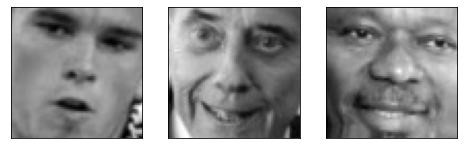

In [2]:
x_pos_orig = []
base_path = "The Main Path of Dataset"
negative_smile = base_path + "negatives\\negatives7\\" #Negative Smiles Path
positive_smile = base_path + "positives\\positives7\\" #Positive Smiles Path

for img in os.listdir(positive_smile):
    x_pos_orig.append(mpimg.imread(positive_smile + img))
    
for img in os.listdir(negative_smile):
    x_pos_orig.append(mpimg.imread(negative_smile + img))

# Change Into np.array and Scale to 255. Which is Max
x_pos_orig = np.array(x_pos_orig)/255.


# Plot 3 random images
plt.figure(figsize=(8, 6))
n = 3
for i in range(n):
    ax = plt.subplot(2, 3, i+1) # Using i+1 Since 0 is Deprecated in Future Matplotlib
    plt.imshow(random.choice(x_pos_orig), cmap=plt.cm.gray)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

# Reshape for Further Use in Our DNN Model
x_pos = x_pos_orig.reshape(len(x_pos_orig),1,64,64)

<ipython-input-4-cfd10c703f0e>:8: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.subplot(3, 2, i)
<ipython-input-4-cfd10c703f0e>:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.subplot(3,2,i+1)


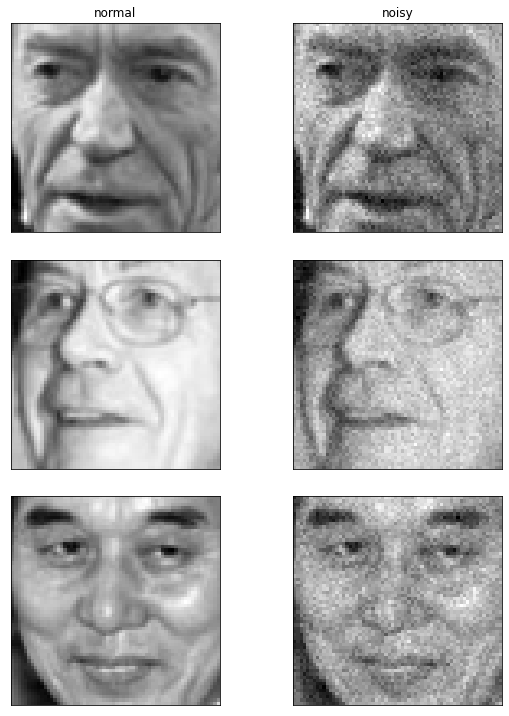

In [4]:
plt.figure(figsize=(8, 10))
plt.subplot(3,2,1).set_title('normal')
plt.subplot(3,2,2).set_title('noisy')
plt.tight_layout()
n = 6
for i in range(1,n+1,2):
    # 2 Columns with Good on left Side, Noisy on Right Side
    ax = plt.subplot(3, 2, i)

    rand_img = random.choice(x_pos)[0]
    random_factor = 0.05 * np.random.normal(loc=0., scale=1., size=rand_img.shape)
    # plot normal images
    plt.imshow(rand_img, cmap=plt.cm.gray)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    # Plot Noisy Images
    ax = plt.subplot(3,2,i+1)

    plt.imshow(rand_img + random_factor, cmap=plt.cm.gray)
    ax.get_yaxis().set_visible(False)
    ax.get_xaxis().set_visible(False)

x_pos = x_pos.reshape(len(x_pos_orig),64,64,1)

In [5]:
# Total Number of images
x_pos.shape[0]

13165

#### >>> 3. Set up our evaluation metric
**Note!** To measure how well our denoiser worked, we have to use a metric, beside accuracy in the training of the model. We have exploited **PSNR**, abbreviated as **Peak signal-to-noise ratio**. You check [this](https://en.wikipedia.org/wiki/Peak_signal-to-noise_ratio) out for more explainations.

In [6]:
import math

#Define a function to measure the PSNR for later use

def psnr(img1, img2):
    '''
    Arguments:
            img1: original image 
            img2: the denoised (courrupted that can either be the noisy or denoised image)
    Out:
            PSNR of the corrupted image
    '''
    
    mse = np.mean( (img1 - img2) ** 2 )
    
    if mse == 0:
        return 100
    
    PIXEL_MAX = np.max(img1)
    return 20 * math.log10(PIXEL_MAX / math.sqrt(mse))

#### >>> 4. Add Noise and Split the Data into train/dev(test) set
As mentioned earlier, we use Additive White Gaussian Noise with different standard deviations.

**Note!**: Since we have normalized our the values of the pixels of our images to be between **0** and **1**. Therefore, a standard deviation of egg. 30 will be a coefficient 30/255 = 0.117. (We are using 8-bit images, as a result the maximum value of each pixel can be 255 and the minimum can be 0)

In [28]:
# Shuffles the data and adds the random noise
# Then, the noisy images are splitted into train and dev(test) sets


np.random.shuffle(x_pos)
x_noisy=[]
for i in range(x_pos.shape[0]):
    random_factor = 0.05 * np.random.normal(loc=0., scale=1., size=x_pos.shape[1:])
    x_noisy.append(x_pos[i] + random_factor)

x_noisy = np.array(x_noisy)


x_train = x_noisy[:int(x_noisy.shape[0]*0.8)]
x_test = x_noisy[int(x_noisy.shape[0]*0.8):]

x_pos_y = x_pos[:int(x_noisy.shape[0]*0.8)]

In [29]:
x_train.shape
x_pos_y_test = x_pos[int(x_noisy.shape[0]*0.8):]

In [31]:
#Noisy Images psnr
psnr(x_pos, x_noisy)

26.02017391776281

In [32]:
x_pos_y.shape

(10532, 64, 64, 1)

#### >>> 5. Define the DNN Model
Here we can see the structure and the architecture of the CNN model. The model is a 4 layer Convolution-Deconvolution with ReLU activation functions.
The sequence is as follows:
**Input-->Conv-->ReLU-->Conv-->ReLU-->DeConv-->ReLU-->DeConv-->ReLU-->Out**

In [33]:
def DCNN(input_shape):
    '''
        Arguments:
            input_shape: shape of the input image
            
        Out:
            returns the model to compile it with our desired loss function, metric and optimizer for training
    '''
    
    X_input = Input(input_shape)
    
    # Coefficients for symmetric connection derived from Zhao paper
    delta0 = 0.1
    delta1 = 0.2
    
    #layers
    X = Conv2D(64, (5,5), strides=(1,1), padding='same', name='conv0', kernel_initializer = glorot_uniform(seed=0))(X_input)
    X = Activation('relu')(X)
    X_0 = X # Saves the Output of the layer to use it for Symmetric Connection - Comment this to avoid Symmetric Connection
    
    X = Conv2D(64, (5,5), strides=(2,2), padding='same', name='conv1', kernel_initializer = glorot_uniform(seed=0))(X)
    X = Activation('relu')(X)
    
    
    X = Conv2DTranspose(64, (5,5), strides=(2,2), padding='same', name='deconv0')(X)
    X = Activation('relu')(X)
    
    X = Add()([(1-delta1)*X_0, X]) # Symmetric Connection - Comment this to avoid Symmetric Connection
    X = Conv2DTranspose(1, (5,5), strides=(1,1), padding='same', name='deconv1')(X)
    X = Activation('relu')(X)
    
    model = Model(inputs = X_input, outputs = X, name='DCNN')
    
    return model

In [34]:
input_shape = x_train.shape[1:] 
DCNN_model = DCNN(input_shape) # Giving the input shape as an input
DCNN_model.summary() # A Summary of Our Model

Model: "DCNN"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 64, 64, 1)]  0                                            
__________________________________________________________________________________________________
conv0 (Conv2D)                  (None, 64, 64, 64)   1664        input_1[0][0]                    
__________________________________________________________________________________________________
activation (Activation)         (None, 64, 64, 64)   0           conv0[0][0]                      
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 32, 32, 64)   102464      activation[0][0]                 
_______________________________________________________________________________________________

In [35]:
x_train.shape[1:]

(64, 64, 1)

#### >>> 6. Compile the model and train it with the training set

We set the **optimizer**, **loss function**, and the **metric** here. In this notebook we use the **Adam optimizer**. You can use **SGD** also for optimizer. See the paper [here](https://arxiv.org/abs/1412.6980).

For all of our models we use the **Pixel-wise Mean Squared Error** loss function to compare the denoised pixels with their ground truth values. Additionally, we use the metric **Accuracy** to compare the images.

In [36]:
DCNN_model.compile(optimizer='adam', loss='mean_squared_error', metrics = ["accuracy"])

In [37]:
DCNN_model.fit(x_train, x_pos_y, epochs=20, batch_size=128)

Epoch 1/20
83/83 [==============================] - 125s 2s/step - loss: 0.0115 - accuracy: 1.7184e-04
Epoch 2/20
83/83 [==============================] - 128s 2s/step - loss: 6.7378e-04 - accuracy: 1.7328e-04
Epoch 3/20
83/83 [==============================] - 129s 2s/step - loss: 5.8179e-04 - accuracy: 1.7328e-04
Epoch 4/20
83/83 [==============================] - 129s 2s/step - loss: 5.2597e-04 - accuracy: 1.7328e-04
Epoch 5/20
83/83 [==============================] - 129s 2s/step - loss: 5.0462e-04 - accuracy: 1.7328e-04
Epoch 6/20
83/83 [==============================] - 123s 1s/step - loss: 4.9524e-04 - accuracy: 1.7328e-04
Epoch 7/20
83/83 [==============================] - 125s 2s/step - loss: 4.7355e-04 - accuracy: 1.7328e-04
Epoch 8/20
83/83 [==============================] - 130s 2s/step - loss: 4.7010e-04 - accuracy: 1.7328e-04
Epoch 9/20
83/83 [==============================] - 126s 2s/step - loss: 4.6174e-04 - accuracy: 1.7328e-04
Epoch 10/20
83/83 [======================

#### >>> 7. Results
After the model is trained, we use **prediction method** to denoise our noisy images and then we plot them and evaluate the performance of the model with our PSNR function we implemented earlier.

In [38]:
x_pred = DCNN_model.predict(x_train[:10])

In [39]:
DCNN_model.save('Path to save the model')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: E:\Projects and Presentations\B.S Final Project\Denoising\CNN\DCNN_SMILEdata\Model\Adam_sym\assets


In [40]:
x_pred.shape

(10, 64, 64, 1)

In [41]:
x_pred = x_pred.reshape(len(x_pred),1,64,64)
x_pos_y_plt = x_pos_y.reshape(len(x_pos_y), 1, 64, 64)
x_train_plt = x_train.reshape(len(x_train),1,64,64)

(-0.5, 63.5, 63.5, -0.5)

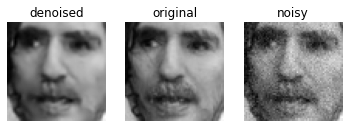

In [42]:
plt.subplot(131).set_title('denoised')
plt.imshow(x_pred[2][0], plt.cm.gray)
plt.axis('off')
plt.subplot(132).set_title('original')
plt.imshow(x_pos_y_plt[2][0], plt.cm.gray)
plt.axis('off')
plt.subplot(133).set_title('noisy')
plt.imshow(x_train_plt[2][0], plt.cm.gray)
plt.axis('off')

(-0.5, 63.5, 63.5, -0.5)

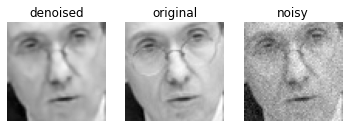

In [43]:
x_pred_test = DCNN_model.predict(x_test[:10])

x_pred_test = x_pred_test.reshape(len(x_pred_test),1,64,64)
x_pos_y_test_plt = x_pos_y_test.reshape(len(x_pos_y_test), 1, 64, 64)
x_test_plt = x_test.reshape(len(x_test),1,64,64)

plt.subplot(131).set_title('denoised')
plt.imshow(x_pred_test[2][0], plt.cm.gray)
plt.axis('off')
plt.subplot(132).set_title('original')
plt.imshow(x_pos_y_test_plt[2][0], plt.cm.gray)
plt.axis('off')
plt.subplot(133).set_title('noisy')
plt.imshow(x_test_plt[2][0], plt.cm.gray)
plt.axis('off')

In [88]:
psnr(x_pos_y_test_plt[2][0],x_pred_test[2][0])

32.376414812874124

In [46]:
#psnr(x_pos_y[2][0],x_pred[2][0])

7.404307668714344

To compare how much the performance of our model, we use both the psnr of the noisy image and the psnr of the cleaned pictures. The results are shown bellow. Feel free to change the arguments to see the difference.

The first cell bellow loads 4 images we chose. We add the random noise to each and then we use the model to clean the noise and observe the performance.

The PSNR is also measured bellow.

In [81]:

results=[]
path = 'E:\Projects and Presentations\B.S Final Project\Denoising\CNN\SMILEsmileD-master\SMILEs\Result_evaluation\\'
for i in os.listdir(path):
    results.append(plt.imread(path + i))
results = np.array(results)


In [82]:
results.shape

(4, 64, 64)

In [83]:
results_test = results.reshape(len(results), 64, 64, 1)
results_test = results_test/255.

In [84]:
results_test_noisy = results_test + 0.05 * np.random.normal(loc=0., scale=1., size=results_test.shape[1:])

In [85]:
results_predict = DCNN_model.predict(results_test_noisy)

In [86]:
results_test_noisy = results_test_noisy.reshape(len(results_test_noisy),64,64)
results_predict_plt = results_predict.reshape(len(results_predict), 64, 64)

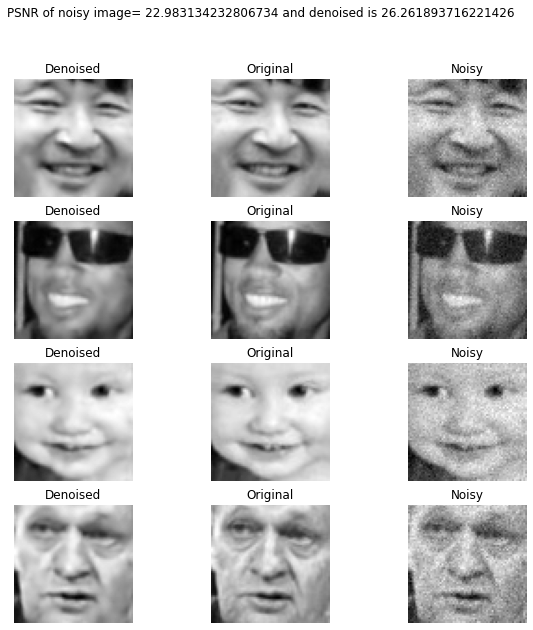

In [87]:
fig, axs = plt.subplots(nrows=4, ncols=3, figsize=(10,10))

fig.suptitle('PSNR of noisy image= {} and denoised is {}'.format(psnr(results[0]/np.max(results), results_test_noisy[0]), psnr(results[0]/np.max(results), results_predict_plt[0])))

for i in range(axs.shape[0]):
    axs[i, 0].imshow(results_predict_plt[i], plt.cm.gray)
    axs[i, 0].set_title('Denoised')
    axs[i, 0].axis('off')
    axs[i, 1].imshow(results[i], plt.cm.gray)
    axs[i, 1].set_title('Original')
    axs[i, 1].axis('off')
    axs[i, 2].imshow(results_test_noisy[i], plt.cm.gray)
    axs[i, 2].set_title('Noisy')
    axs[i, 2].axis('off')

plt.savefig('DCNN_15kImage_4layer_5in5_adam_symetric_results.png')

-------------------------------------------------------------------------------------------------------------
Check out the other models in other notebooks!

**Contact us:**

Kamyar Arshi (Kamyararshi@gmail.com)

Seyed Mohammad Mehdi Hosseini (Smmehdihosseini@gmail.com)